## 介紹

先前的教程展示了一個簡單的線性模型，對MNIST數據集中手寫數字的識別率達到了91%。

在這個教程中，我們會在 Conx 中實現一個簡單的捲積神經網絡，它能達到大約 99% 的分類準確率，如果你做了一些建議的練習，準確率還可能更高。

卷積神經網絡在一張輸入圖片上移動一個小的濾波器。這意味著在遍歷整張圖像來識別模式時，要重複使用這些濾波器。這讓卷積神經網絡在擁有相同數量的變量時比全連接網絡（Fully-Connected）更強大，也讓卷積神經網絡訓練得更快。

## 流程圖

下面的圖表直接顯示了之後實現的捲積神經網絡中數據的傳遞。

輸入圖像在第一層卷積層裡使用權重過濾器處理。結果在16張新圖裡，每張代表了卷積層裡一個過濾器（的處理結果）。圖像經過降採樣，分辨率從28x28減少到14x14。

16張小圖在第二個卷積層中處理。這16個通道以及這層輸出的每個通道都需要一個過濾權重。總共有36個輸出，所以在第二個卷積層有16 x 36 = 576個濾波器。輸出圖再一次降採樣到7x7個像素。

第二個卷積層的輸出是36張7x7像素的圖像。它們被轉換到一個長為7 x 7 x 36 = 1764的向量中去，它作為一個有128個神經元（或元素）的全連接網絡的輸入。這些又輸入到另一個有10個神經元的全連接層中，每個神經元代表一個類別，用來確定圖像的類別，即圖像上的數字。

卷積濾波一開始是隨機挑選的，因此分類也是隨機完成的。根據交叉熵（cross-entropy）來測量輸入圖預測值和真實類別間的錯誤。然後優化器用鍊式法則自動地將這個誤差在卷積網絡中傳遞，更新濾波權重來提升分類質量。這個過程迭代了幾千次，直到分類誤差足夠低。

這些特定的濾波權重和中間圖像是一個優化結果，和你執行代碼所看到的可能會有所不同。


### 卷積層
下面的圖片展示了在第一個卷積層中處理圖像的基本思想。輸入圖片描繪了數字7，這裡顯示了它的四張拷貝，我們可以很清晰的看到濾波器是如何在圖像的不同位置移動。在濾波器的每個位置上，計算濾波器以及濾波器下方圖像像素的點乘，得到輸出圖像的一個像素。因此，在整張輸入圖像上移動時，會有一張新的圖像生成。

紅色的濾波權重表示濾波器對輸入圖的黑色像素有正響應，藍色的代表有負響應。

在這個例子中，很明顯這個濾波器識別數字7的水平線段，在輸出圖中可以看到它對線段的強烈響應。

濾波器遍歷輸入圖的移動步長稱為stride。在水平和豎直方向各有一個stride。

在下面的源碼中，兩個方向的stride都設為1，這說明濾波器從輸入圖像的左上角開始，下一步移動到右邊1個像素去。當濾波器到達圖像的右邊時，它會返回最左邊，然後向下移動1個像素。持續這個過程，直到濾波器到達輸入圖像的右下角，同時，也生成了整張輸出圖片。

當濾波器到達輸入圖的右端或底部時，它會用零（白色像素）來填充。因為輸出圖要和輸入圖一樣大。

此外，卷積層的輸出可能會傳遞給修正線性單元（ReLU），它用來保證輸出是正值，將負值置為零。輸出還會用最大池化(max-pooling)進行降採樣，它使用了2x2的小窗口，只保留像素中的最大值。這讓輸入圖分辨率減小一半，比如從28x28到14x14。

第二個卷積層更加複雜，因為它有16個輸入通道。我們想給每個通道一個單獨的濾波，因此需要16個。另外，我們想從第二個卷積層得到36個輸出，因此總共需要16 x 36 = 576個濾波器。要理解這些如何工作可能有些困難。

In [23]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import conx as cx
from tensorflow.examples.tutorials.mnist import input_data
from sklearn.metrics import confusion_matrix

# check 一下 tensorflow 的版本
print (f"TensorFlow Version: {tf.__version__}")


# printing a short description of its contents.
mnist = cx.Dataset.get('mnist')
mnist.info()

mnist.summary()

# take a look at some input patterns
# cx.view(mnist.inputs[0])

# split the data into 60,000 training patterns and 10,000 testing patterns, and then verify the split:
mnist.split(10000)
mnist.split()

print(len(mnist.inputs), 'total images')
print(len(mnist.train_inputs), 'images for training')
print(len(mnist.test_inputs), 'images for testing')

TensorFlow Version: 2.0.0


**Dataset**: Unnamed Dataset

**Information**:
   * name    : None
   * length  : 70000

**Input Summary**:
   * shape  : (28, 28, 1)
   * range  : (0.0, 1.0)

**Target Summary**:
   * shape  : (10,)
   * range  : (0, 1)



_________________________________________________________________
Unnamed Dataset:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0, 1)                        
Total patterns: 70000
   Training patterns: 70000
   Testing patterns: 0
_________________________________________________________________
70000 total images
60000 images for training
10000 images for testing


## 神經網絡的配置

我們將使用兩個 5×5 的捲積層定義一個 MNIST 分類的 CNN，每個卷積層之後是一個具有 2×2 的池化層，用於計算輸入的最大值。 第一卷積層將學習 16 個相對較低級別的特徵，而第二個卷積層將學習 32 個較高級別的特徵。 然後，這些特徵將匯入隱藏層（在展平後），然後用 softmax 的輸出分類層。

In [24]:
cnn = cx.Network("MNIST_CNN")

cnn.add(cx.Layer("input", (28,28,1), colormap="gray"),
        cx.Conv2DLayer("conv2D_1", 16, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool1", (2,2)),
        cx.Conv2DLayer("conv2D_2", 32, (5,5), activation="relu", dropout=0.20),
        cx.MaxPool2DLayer("maxpool2", (2,2)),
        cx.FlattenLayer("flat"),
        cx.Layer("hidden", 30, activation='relu'),
        cx.Layer("output", 10, activation='softmax'))

cnn.connect()

Notice that each convolution layer in the network includes a dropout setting of 20%. Dropout is a technique that helps to improve a network’s ability to generalize what it has learned, by making it less sensitive to noise and to irrelevant correlations that may exist in the training data. During training, a randomly chosen subset of units in a dropout layer (here, 20% of the units) will be turned off (set to zero activation) on each training cycle, with different random subsets being chosen on each cycle. Dropout only occurs during training; after the network has learned, all units participate in the classification of input data.

Next, we need to initialize our dataset and then compile the network.

In [25]:
cnn.get_dataset("MNIST")
cnn.dataset.split(10000)
cnn.dataset.summary()

_________________________________________________________________
MNIST_CNN Dataset:
Patterns    Shape                 Range                         
inputs      (28, 28, 1)           (0.0, 1.0)                    
targets     (10,)                 (0, 1)                        
Total patterns: 70000
   Training patterns: 60000
   Testing patterns: 10000
_________________________________________________________________


we will try the **RMSprop algorithm** , which automatically adjusts the learning rate and momentum as training proceeds.

In [26]:
cnn.compile(error='categorical_crossentropy', optimizer='rmsprop')
cnn.summary()

Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv2D_1 (Conv2D)            (None, 24, 24, 16)        416       
_________________________________________________________________
dropout_11 (Dropout)         (None, 24, 24, 16)        0         
_________________________________________________________________
maxpool1 (MaxPooling2D)      (None, 12, 12, 16)        0         
_________________________________________________________________
conv2D_2 (Conv2D)            (None, 8, 8, 32)          12832     
_________________________________________________________________
dropout_12 (Dropout)         (None, 8, 8, 32)          0         
_________________________________________________________________
maxpool2 (MaxPooling2D)      (None, 4, 4, 32)          0  

Training our CNN on the full dataset will take a long time, so in the interest of brevity, let’s reduce the size of our dataset by 80% using the chop method, which deletes the specified fraction of data from the dataset.

**小結：用一部分的資料來計算，目的是為了省時**

In [27]:
print('Starting with', len(cnn.dataset), 'patterns')
cnn.dataset.chop(0.80)
print(len(cnn.dataset), 'patterns left after chop')

Starting with 70000 patterns


14000 patterns left after chop


In [28]:
cnn.dataset.split(0.25)
cnn.dataset.split()

(10500, 3500)

# 接下來我們要開始迭帶，在這之前解釋更詳細說明一下迭帶

## batch

深度學習的優化算法，說白了就是梯度下降。每次的參數更新有兩種方式。

第一種，遍歷全部數據集算一次損失函數，然後算函數對各個參數的梯度，更新梯度。這種方法每更新一次參數都要把數據集裡的所有樣本都看一遍，計算量開銷大，計算速度慢，不支持在線學習，這稱為 Batch gradient descent，批梯度下降。

另一種，每看一個數據就算一下損失函數，然後求梯度更新參數，這個稱為隨機梯度下降，stochastic gradient descent。這個方法速度比較快，但是收斂性能不太好，可能在最優點附近晃來晃去，hit 不到最優點。兩次參數的更新也有可能互相抵消掉，造成目標函數震盪的比較劇烈。

為了克服兩種方法的缺點，現在一般採用的是一種折中手段，mini-batch gradient decent，小批的梯度下降，這種方法把數據分為若干個批，按批來更新參數，這樣，一個批中的一組數據共同決定了本次梯度的方向，下降起來就不容易跑偏，減少了隨機性。另一方面因為批的樣本數與整個數據集相比小了很多，計算量也不是很大。

基本上現在的梯度下降都是基於 mini-batch 的，所以深度學習框架的函數中經常會出現 **batch_size**，就是指這個。

關於如何將訓練樣本轉換從 batch_size 的格式可以參考訓練樣本的 batch_size 數據。


## iterations

iterations（疊代）：每一次疊代都是一次權重更新，每一次權重更新需要 batch_size 個數據進行 Forward 運算得到損失函數，再 BP 算法更新參數。
1 次 iteration 等於使用 batchsize 個樣本訓練一次。

## epochs

epochs被定義為向前和向後傳播中所有批次的單次訓練疊代。這意味著 1 個周期是整個輸入數據的單次向前和向後傳遞。簡單說，epochs 指的就是訓練過程中數據將被「輪」多少次，就這樣。

### 舉個例子

訓練集有 1000 個樣本，batchsize = 10，那麼：

訓練完整個樣本集需要：

100 次 iteration，1次epoch。

具體的計算公式為：

one epoch = numbers of iterations = N = 訓練樣本的數量/batch_size


[原文網址](https://kknews.cc/code/kban458.html)

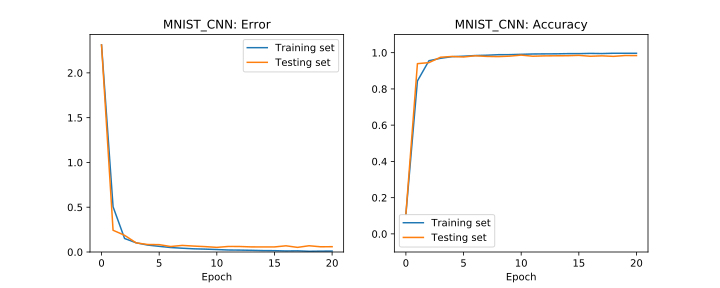

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   20 |   0.01029 |   0.99686 |   0.05921 |   0.98400 


In [29]:
cnn.reset()
cnn.train(epochs=20)

# 來看看哪裡錯了

In [30]:
results = [cnn.propagate(img) for img in cnn.dataset.test_inputs]
classifications = [cx.argmax(r) for r in results]
correct_answers = [cx.argmax(t) for t in cnn.dataset.test_targets]
wrong = [i for i in range(len(classifications)) if classifications[i] != correct_answers[i]]
print('Network classified the following', len(wrong), 'test inputs incorrectly:')
print(wrong)
print(f"準確率: {(len(correct_answers)/ (len(correct_answers)+len(wrong)))*100}%")
print(f"錯誤率: {(len(wrong)/ (len(correct_answers)+len(wrong)))*100}%")

Network classified the following 56 test inputs incorrectly:
[300, 352, 384, 444, 470, 482, 486, 492, 539, 544, 568, 604, 710, 792, 842, 982, 1072, 1147, 1237, 1267, 1330, 1385, 1440, 1576, 1653, 1683, 1720, 1732, 1772, 1777, 1797, 1805, 1872, 1877, 2059, 2103, 2146, 2151, 2179, 2332, 2384, 2436, 2467, 2485, 2531, 2582, 2593, 2627, 2888, 2910, 3008, 3177, 3238, 3354, 3412, 3469]
準確率: 98.4251968503937%
錯誤率: 1.574803149606299%


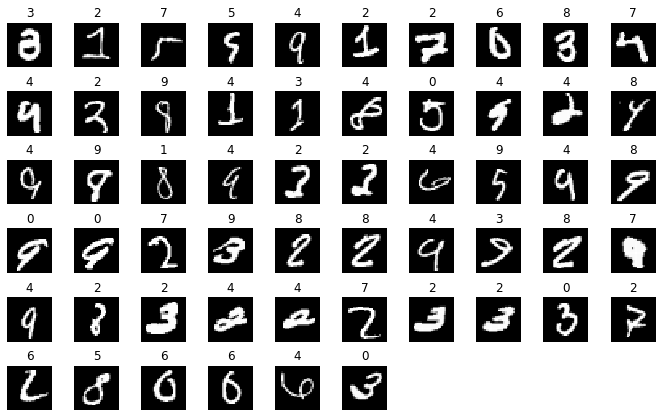

In [31]:
# 畫出來
misclassifications = [classifications[i] for i in wrong]
cx.view(cnn.dataset.test_inputs[wrong], labels=misclassifications, layout=(None,10), spacing=0.5)